# Exploring Question Answering with Huggingface Transformers

### Let's try the default question-answering pipeline first

In [1]:
from transformers import pipeline
import pandas as pd
import torch

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
qa_model = pipeline("question-answering")

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [3]:
question = "Where is the ball?"
context = "The chair is near the table, and the ball is behind the chair."

In [4]:
qa_model(question = question, context = context)

{'score': 0.8110503554344177,
 'start': 45,
 'end': 61,
 'answer': 'behind the chair'}

#### How about something longer

In [5]:
text = """Dear Amazon, last week I ordered an Optimus Prime action figure \
from your online store in Germany. Unfortunately, when I opened the package, \
I discovered to my horror that I had been sent an action figure of Megatron \
instead! As a lifelong enemy of the Decepticons, I hope you can understand my \
dilemma. To resolve the issue, I demand an exchange of Megatron for the \
Optimus Prime figure I ordered. Enclosed are copies of my records concerning \
this purchase. I expect to hear from you soon. Sincerely, Bumblebee."""

In [6]:
question = "What does the customer want?"
outputs = qa_model(question=question, context=text)
pd.DataFrame.from_records([outputs])

,score,start,end,answer
0,0.631292,335,358,an exchange of Megatron


## Let's get more detailed and just directly use the model

#### Either use BertForQuestionAnswering or AutoModel approach

### Here is the AutoModel approach

In [7]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

model_ckpt = "bert-large-uncased-whole-word-masking-finetuned-squad"
#model_ckpt = "deepset/xlm-roberta-base-squad2"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

In [8]:
question = '''What is Machine Learning?'''

paragraph = ''' Machine learning (ML) is the scientific study of algorithms and statistical models that computer systems use to progressively improve their performance 
                on a specific task. Machine learning algorithms build a mathematical model of sample data, known as "training data", in order to make predictions or 
                decisions without being explicitly programmed to perform the task. Machine learning algorithms are used in the applications of email filtering, detection 
                of network intruders, and computer vision, where it is infeasible to develop an algorithm of specific instructions for performing the task. Machine learning 
                is closely related to computational statistics, which focuses on making predictions using computers. The study of mathematical optimization delivers methods, 
                theory and application domains to the field of machine learning. Data mining is a field of study within machine learning, and focuses on exploratory 
                data analysis through unsupervised learning.In its application across business problems, machine learning is also referred to as predictive analytics. '''

In [9]:
len(paragraph.split(' '))

250

In [10]:
# Use encode_plus because we are encoding the question and the context
encoding = tokenizer.encode_plus(text=question, text_pair=paragraph)

In [11]:
encoding

{'input_ids': [101, 2054, 2003, 3698, 4083, 1029, 102, 3698, 4083, 1006, 19875, 1007, 2003, 1996, 4045, 2817, 1997, 13792, 1998, 7778, 4275, 2008, 3274, 3001, 2224, 2000, 20519, 5335, 2037, 2836, 2006, 1037, 3563, 4708, 1012, 3698, 4083, 13792, 3857, 1037, 8045, 2944, 1997, 7099, 2951, 1010, 2124, 2004, 1000, 2731, 2951, 1000, 1010, 1999, 2344, 2000, 2191, 20932, 2030, 6567, 2302, 2108, 12045, 16984, 2000, 4685, 1996, 4708, 1012, 3698, 4083, 13792, 2024, 2109, 1999, 1996, 5097, 1997, 10373, 22910, 1010, 10788, 1997, 2897, 22841, 2015, 1010, 1998, 3274, 4432, 1010, 2073, 2009, 2003, 1999, 7959, 21369, 3468, 2000, 4503, 2019, 9896, 1997, 3563, 8128, 2005, 4488, 1996, 4708, 1012, 3698, 4083, 2003, 4876, 3141, 2000, 15078, 6747, 1010, 2029, 7679, 2006, 2437, 20932, 2478, 7588, 1012, 1996, 2817, 1997, 8045, 20600, 18058, 4725, 1010, 3399, 1998, 4646, 13100, 2000, 1996, 2492, 1997, 3698, 4083, 1012, 2951, 5471, 2003, 1037, 2492, 1997, 2817, 2306, 3698, 4083, 1010, 1998, 7679, 2006, 4654, 247

Notice that we get not only the input_ids and attention_mask like normal <br>
We also get token_type_ids that indicate the question tokens (0) and the context tokens (1) for BERT

In [12]:
inputs = encoding['input_ids']  # Token embeddings

if(not "roberta" in model_ckpt):
    sentence_embedding = encoding['token_type_ids']  # Segment embeddings - only needed for BERT
    
tokens = tokenizer.convert_ids_to_tokens(inputs) # input tokens

In [13]:
if("roberta" in model_ckpt):
    scores = model(input_ids=torch.tensor([inputs]))
else:
    # BERT needs token_type_ids which mask the question and answer
    scores = model(input_ids=torch.tensor([inputs]), token_type_ids=torch.tensor([sentence_embedding]))

In [14]:
scores

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-5.7542, -4.3813, -6.5904, -7.5645, -8.9276, -8.6470, -5.7542, -0.3306,
         -4.4684, -2.9009,  0.3908, -5.2133,  2.5332,  5.5022,  5.3616,  0.7822,
         -0.0102,  4.9764, -2.6878,  1.9115, -0.9204, -2.9185,  1.7439, -2.3654,
         -2.0708, -1.7757, -0.9276, -1.9161, -4.9297, -3.0267, -4.8251, -4.6447,
         -4.3884, -2.8900, -5.7541, -0.8635, -5.4572, -0.9168, -1.8347, -2.9211,
         -1.5956, -4.0895, -5.9067, -3.0222, -4.5092, -6.8737, -4.8453, -6.3691,
         -2.5550, -1.7856, -5.5590, -6.7446, -6.9368, -4.4873, -5.3093, -3.9420,
         -3.4155, -3.1755, -7.3336, -4.3958, -4.2978, -6.7310, -5.0014, -5.0726,
         -7.5880, -6.8129, -7.9276, -5.5676, -7.3021, -3.3388, -6.8694, -4.4947,
         -7.5816, -5.6622, -7.4796, -6.8272, -4.7013, -7.7852, -4.5031, -5.9537,
         -8.2277, -5.2420, -8.2161, -6.5695, -7.5492, -8.0937, -8.5280, -7.8790,
         -4.4530, -6.2128, -7.7891, -5.4337, -5.3095, -7

In [15]:
start_index = torch.argmax(scores['start_logits'])

end_index = torch.argmax(scores['end_logits'])

In [16]:
start_index, end_index

(tensor(13), tensor(20))

In [17]:
answer = ' '.join(tokens[start_index:end_index+1])

In [18]:
answer

'the scientific study of algorithms and statistical models'

#### Let's visualize the return values to get a sense of what is going on

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

In [20]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = scores['start_logits'].detach().numpy().flatten()
e_scores = scores['end_logits'].detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

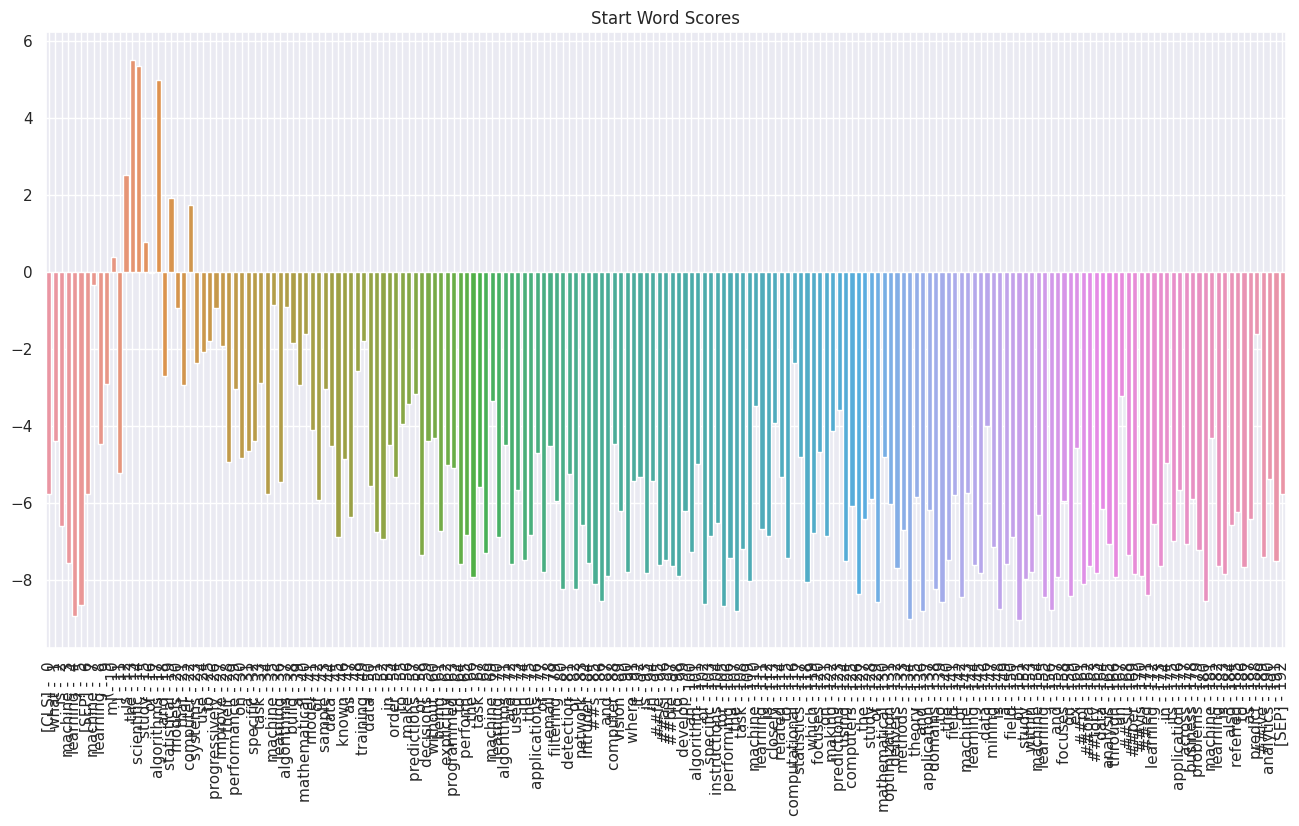

In [21]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

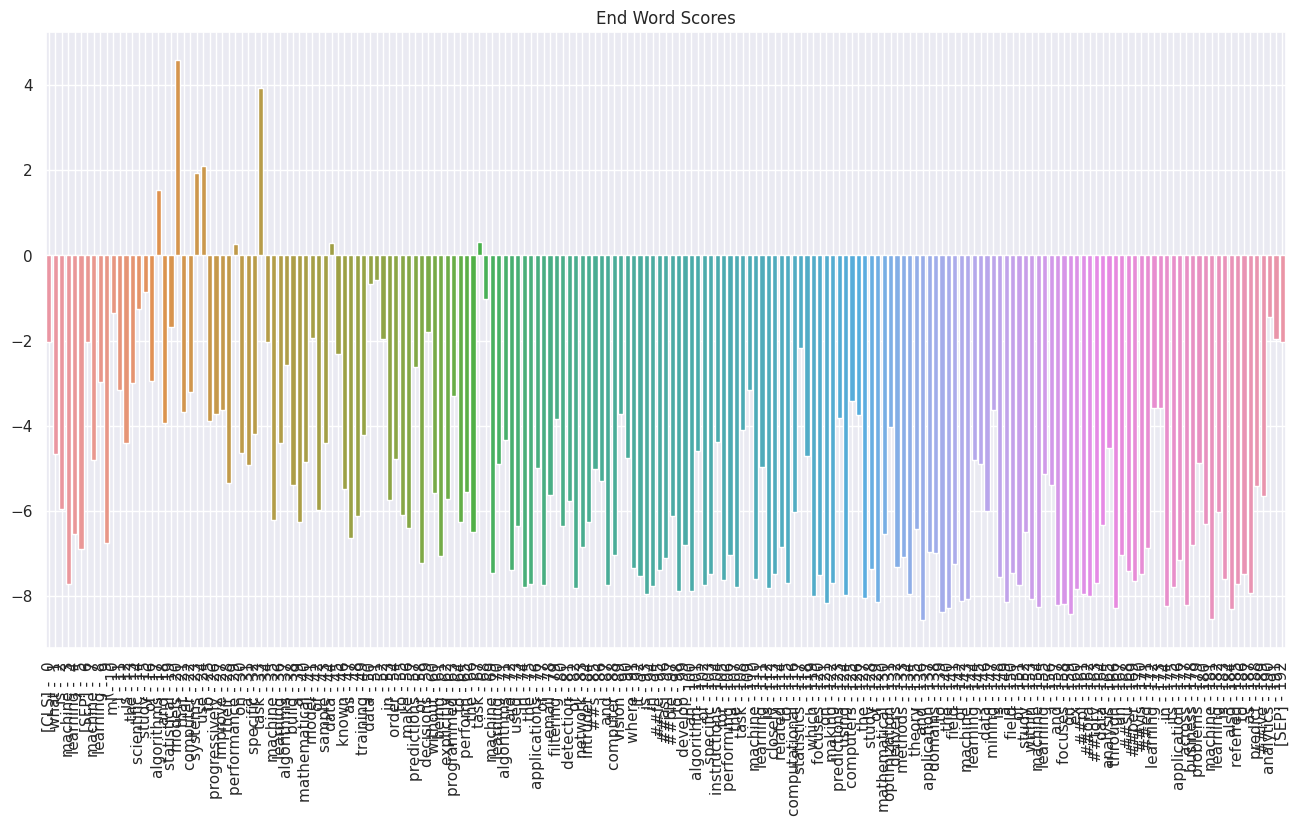

In [22]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

#### Sliding Windows

For long documents, we generally break up the data into overlapping windows <br>
then run the model with the question on all the windows

In [23]:
windows = []
encodings = []
windowtokens = []
for i in range(0, 4):
    windows.append(" ".join(paragraph.split()[i*25:i*25+50]))
    encodings.append(tokenizer.encode_plus(text=question,text_pair=windows[i]))
    windowtokens.append(tokenizer.convert_ids_to_tokens(encodings[i]['input_ids']))


In [24]:
encodings

[{'input_ids': [101, 2054, 2003, 3698, 4083, 1029, 102, 3698, 4083, 1006, 19875, 1007, 2003, 1996, 4045, 2817, 1997, 13792, 1998, 7778, 4275, 2008, 3274, 3001, 2224, 2000, 20519, 5335, 2037, 2836, 2006, 1037, 3563, 4708, 1012, 3698, 4083, 13792, 3857, 1037, 8045, 2944, 1997, 7099, 2951, 1010, 2124, 2004, 1000, 2731, 2951, 1000, 1010, 1999, 2344, 2000, 2191, 20932, 2030, 6567, 2302, 2108, 12045, 16984, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [101, 2054, 2003, 3698, 4083, 1029, 102, 3698, 4083, 13792, 3857, 1037, 8045, 2944, 1997, 7099, 2951, 1010, 2124, 2004, 1000, 2731, 2951, 1000,

In [25]:
windowscores = []
answers = []
for i in range(0, 4):
    if ("roberta" in model_ckpt):
        # RoBERTa doesn't need the token_type_ids to mask the question vs the answer
        windowscores.append(model(input_ids=torch.tensor([encodings[i]['input_ids']])))
    else:
        # Use for BERT
        windowscores.append(model(input_ids=torch.tensor([encodings[i]['input_ids']]), 
                                  token_type_ids=torch.tensor([encodings[i]['token_type_ids']])))
    

    
    start_index = torch.argmax(windowscores[i]['start_logits'])
    end_index = torch.argmax(windowscores[i]['end_logits'])
    start_logit = windowscores[i]['start_logits'][0][start_index]
    answer = ' '.join(windowtokens[i][start_index:end_index+1])
    answers.append((start_index, end_index, start_logit, answer))

In [26]:
answers

[(tensor(13),
  tensor(20),
  tensor(5.3537, grad_fn=<SelectBackward0>),
  'the scientific study of algorithms and statistical models'),
 (tensor(9),
  tensor(23),
  tensor(3.6210, grad_fn=<SelectBackward0>),
  'algorithms build a mathematical model of sample data , known as " training data "'),
 (tensor(7),
  tensor(14),
  tensor(2.4437, grad_fn=<SelectBackward0>),
  'to perform the task . machine learning algorithms'),
 (tensor(29),
  tensor(38),
  tensor(1.6924, grad_fn=<SelectBackward0>),
  'computational statistics , which focuses on making predictions using computers')]

#### How do we tell which is the right answer?

Since we are using the raw logits and not normalizing, <br>
we can directly compare the logit values. 
Choose the highest logits.